# 2. Построение baseline-модели
- настройка классификатора под три класса
- разделение выборки train / valid
- настройка и использование предобученной ResNet18 (ImageNet)
- балансировка классов
- обучение на train-выборке, валидация на validation-выборке
- инференс модели и расчет **Accuracy** и **F1-score** (валидационная выборка)
- построение confusion matrix
- сохранение отчета метрик модели в csv
- использование Grad-CAM

### 2.1. Обоснование выбора архитектуры нейронной сети

Для построения базовой модели классификации снимков грудной клетки была выбрана архитектура **ResNet18** (*Residual Neural Network*).  

Основные причины выбора:

1. **Оптимальный баланс точности и вычислительной сложности.**  
   ResNet18 - относительно компактная (примерно 11 млн параметров) сеть, что позволяет обучать ее даже на видеокартах с 6 ГБ VRAM, сохраняя при этом хорошее качество классификации.

2. **Использование предобученных весов (Transfer Learning*).**
   Модель предобучена на датасете ImageNet и уже умеет распознавать базовые визуальные паттерны - контуры, текстуры, градиенты яркости.
   Это позволяет ускорить обучение и повысить обобщающую способность на медицинских изображениях при небольшой выборке (26684 записей).

3. **Хорошая интерпретируемость.**
   ResNet хорошо подходит для визуализации карт активаций (Grad-CAM*), что важно при медицинской интерпретации - можно показать, на какие области легких модель опирается при классификации.

Таким образом, ResNet18 является рациональным выбором для BASE_DIRline-модели - достаточно мощной для выявления закономерностей, но при этом легкой и интерпретируемой.

---

### 2.2. Разделение данных на выборки

Для обучения и оценки модели данные будут разделены на три части:
- **train** - 80% данных для обучения весов сети,  
- **validation** - 20% данных для подбора гиперпараметров и контроля переобучения,  
- **test** - (будет сформирована позже) для финальной независимой оценки качества.

Разбиение выполняется по принципу **стратифицированного разбиения** (`stratified split`), чтобы сохранить одинаковое соотношение классов (`Normal`, `Lung Opacity`, `No Lung Opacity / Not Normal`) в каждой выборке.  

Это важно, поскольку классы не сбалансированы, и простое случайное разбиение может исказить пропорции.

---

### 2.3. Архитектура модели

Архитектура BASE_DIRline-модели основана на **ResNet18**, модифицированной для одноканальных медицинских изображений:

1. **Входной слой** - адаптирован под 1 канал (вместо стандартных 3 RGB, поскольку рентгеновские снимки черно-белые).
   ```python
   model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
   ```
2. **Feature extractor** (основная часть ResNet) - извлекает визуальные признаки с разных уровней абстракции: контуры, плотность тканей, затемнения, симметрию легких и т.д.
Блоки объединены остаточными связями (residual connections).

3. **Global Average Pooling*** - агрегирует пространственные карты признаков в компактный вектор признаков размерности 512.

4. **Полносвязный классификатор** - заменен на трехклассовый выход (под нашу задачу):
   ```python
   model.fc = nn.Linear(in_features=512, out_features=3)
   ```

5. **Функция активации на выходе** - Softmax*, которая преобразует логиты* в вероятности классов.

---

### 2.4. Процесс обучения

- **Функция потерь: CrossEntropyLoss**, так как задача - многоклассовая классификация.

- **Оптимизатор: AdamW**, хорошо подходит для задач с transfer learning.

- **Метрики оценки: Accuracy и F1-score (macro)**, чтобы учитывать влияние дисбаланса классов.

- Сохраняем лучший чекпойнт по валидационной выборке, обучение идет фиксированное число эпох - 5, без досрочной остановки.
После каждой эпохи модель будет оцениваться на валидационной выборке.
Лучшие веса по метрике F1 сохраняются в директорию models/BASE_DIRline_resnet18.pth.

- Запускаем Grad-Cam для того, чтобы визуально оценить, куда модель смотрит при определении класса легких
---

### 2.5. Ожидаемые результаты

**Baseline-модель призвана:**

- подтвердить корректность пайплайна данных и процесса обучения,
- дать отправную точку для улучшения (transfer learning, fine-tuning*, аугментации*),
- продемонстрировать, что архитектура ResNet способна распознавать основные визуальные признаки пневмонии на рентгеновских снимках.

### Ссылки:

* Transfer Learning (обучение с переносом) - Вместо того чтобы обучать сеть 'с нуля', мы переносим уже выученные признаки (контуры, формы, текстуры) и дообучаем только последние слои под конкретную задачу (например, пневмонию).

* Grad-CAM (Gradient-weighted Class Activation Mapping) - Метод визуализации, который показывает, на какие области изображения смотрит нейросеть при принятии решения.

* Global Average Pooling (Глобальное среднее по признакам) - Операция, которая усредняет значения всех активаций (feature maps) по пространственным координатам, позволяет 'сжать' каждую карту признаков в одно число и сделать модель независимой от размера изображения.

* Логиты - показывают 'уверенность' сети по каждому классу - могут быть как положительные, так и отрицательные.

* Softmax - Функция, которая превращает логиты в вероятности классов, нормируя их так, чтобы сумма равнялась 1. Чем больше логит, тем выше вероятность. Используется в задачах многоклассовой классификации.

* Fine-tuning (тонкая настройка) - Этап после transfer learning, когда размораживаются (разрешаем обновлять веса) некоторые верхние слои предобученной сети и дообучаются уже на новых данных.

* Аугментации (Data Augmentation) - Искусственное увеличение выборки данных, это помогает улучшить обобщающую способность модели и уменьшить переобучение.

Примечание: Данный ноутбук будет использоваться как локально, так и в Kaggle для обучения модели для лучшей воспроизводимости.

# Контроль запуска - первый запуск или нет

In [ ]:
IS_FIRST_RUN = False # Если не хотите заново дообучать модель и вы скачали baseline_resnet18.pth можно оставить False.
SEED = 42

### Библиотеки

In [2]:
import sys
from pathlib import Path # удобная работа с путями (совместима с Windows/Linux)
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
# ----------------------------техническая строка-------------------------------
import random                  # работа с путями и генераторами случайных чисел
import numpy as np                 # численные операции и работа с массивами
import torch                       # основной фреймворк PyTorch для нейронных сетей
import pandas as pd                # работа с табличными данными (DataFrame)
import matplotlib.pyplot as plt    # визуализация графиков и изображений
import torch.nn as nn              # модуль для построения нейросетей (Linear, Conv, и т.д.)
from PIL import Image              # загрузка и обработка изображений (PNG, JPEG)
from pytorch_grad_cam import GradCAM # библиотека для использования GRAD-CAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms  # стандартные трансформации изображений (resize, flip, tensor)
from torch.utils.data import DataLoader  # классы для создания датасетов и загрузчиков данных
from sklearn.model_selection import train_test_split  # разбиение данных на train/val
from sklearn.metrics import (                         # расчет метрик качества
    classification_report,                            # табличный отчет по precision/recall/F1
    confusion_matrix,                                 # матрица ошибок
    ConfusionMatrixDisplay                            # визуализация матрицы ошибок
)

# src
from src.models import (
    compute_class_weights,
    RSNADataset,
    ResNet18Baseline,
    model_fit,
    predictions_on_validation
)
from src.reports import (
    save_model_report
)
from src.grad_cam import show_gradcam_png_grid

In [3]:
# Проверяем параметры графической карты
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available!')
    print('Device name:', torch.cuda.get_device_name(0))
    print(f'Cuda version: {torch.version.cuda}')
else:
    print('CUDA is not available.')

CUDA is available!
Device name: NVIDIA GeForce RTX 3060 Laptop GPU
Cuda version: 12.4


Все доступно, двигаемся дальше!

In [4]:
# Воспроизводимость для KAGGLE / локально
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False; torch.backends.cudnn.benchmark = True

# среда
ON_KAGGLE = Path('/kaggle/input').exists()

if ON_KAGGLE:
    BASE_DIR = Path('/kaggle/working')
    INPUT_DIR = Path('/kaggle/input/rsna-pneumonia-processed-png-meta')  # имя датасета на Kaggle
    PROC_DIR = INPUT_DIR
else:
    BASE_DIR = Path.cwd().parent
    PROC_DIR = BASE_DIR / 'data' / 'processed'

IMG_DIR = PROC_DIR / 'train_png'
META_DIR = PROC_DIR / 'meta_info_encoded.csv'

MODELS_DIR = BASE_DIR / 'models'; MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_FIG = BASE_DIR / 'reports' / 'figures'; REPORTS_FIG.mkdir(parents=True, exist_ok=True)

print('ON_KAGGLE:', ON_KAGGLE)
print('IMG_DIR:', IMG_DIR)
print('META_DIR:', META_DIR)

ON_KAGGLE: False
IMG_DIR: c:\Users\alexf\Desktop\rsna_pneumonia_project\data\processed\train_png
META_DIR: c:\Users\alexf\Desktop\rsna_pneumonia_project\data\processed\meta_info_encoded.csv


### Настройка классификатора под три класса

In [5]:
meta_info_encoded = pd.read_csv(META_DIR)

# трехклассовая цель создаем новый признак (закодированный)
CLASS_MAP = {'Normal':0, 'Lung Opacity':1, 'No Lung Opacity / Not Normal':2}
meta_info_encoded['class_id'] = meta_info_encoded['class'].map(CLASS_MAP)
meta_info_encoded.head(10)

,patientId,class,age,rows,cols,sex_F,sex_M,vp_AP,vp_PA,spacing_x,spacing_y,class_id
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,51.0,1024,1024,True,False,False,True,0.143000,0.143000,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,48.0,1024,1024,True,False,False,True,0.194311,0.194311,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,19.0,1024,1024,False,True,True,False,0.168000,0.168000,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,28.0,1024,1024,False,True,False,True,0.143000,0.143000,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,32.0,1024,1024,True,False,True,False,0.139000,0.139000,1
5,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,54.0,1024,1024,False,True,True,False,0.139000,0.139000,2
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,78.0,1024,1024,False,True,False,True,0.143000,0.143000,2
7,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,75.0,1024,1024,False,True,False,True,0.143000,0.143000,1
8,008c19e8-a820-403a-930a-bc74a4053664,No Lung Opacity / Not Normal,59.0,1024,1024,True,False,False,True,0.194311,0.194311,2
9,009482dc-3db5-48d4-8580-5c89c4f01334,Normal,63.0,1024,1024,False,True,False,True,0.143000,0.143000,0


### Разделение выборки train / valid

In [6]:
train, valid = train_test_split(
    meta_info_encoded['patientId'], 
    test_size=0.2, # 80/20
    random_state=SEED,
    stratify=meta_info_encoded['class_id'] # стратифицируем выборку (важно)
)

# Размеры выборок
df_train = meta_info_encoded[meta_info_encoded.patientId.isin(train)].reset_index(drop=True)
df_val = meta_info_encoded[meta_info_encoded.patientId.isin(valid)].reset_index(drop=True)

# Проверка стратифицированного сплита
print(f'Размеры выборки: \n Train: {len(df_train)} \n Valid: {len(df_val)}\n')
print(f'Выборка до разделения: \n{meta_info_encoded['class'].value_counts(normalize=True)}\n')
print(f'Выборка Train: \n{df_train['class'].value_counts(normalize=True)}\n')
print(f'Выборка Valid: \n{df_val['class'].value_counts(normalize=True)}')

Размеры выборки: 
 Train: 21347 
 Valid: 5337

Выборка до разделения: 
class
No Lung Opacity / Not Normal    0.443000
Normal                          0.331697
Lung Opacity                    0.225304
Name: proportion, dtype: float64

Выборка Train: 
class
No Lung Opacity / Not Normal    0.443013
Normal                          0.331709
Lung Opacity                    0.225278
Name: proportion, dtype: float64

Выборка Valid: 
class
No Lung Opacity / Not Normal    0.442945
Normal                          0.331647
Lung Opacity                    0.225408
Name: proportion, dtype: float64


Мы получили размеры выборок: train = 21347, val = 5337, суммарно 26684, таким образом мы правильно разделили выборки.

Доли классов составляют:
- в общей, train и val - практически идентичны, расхождения минимальные, значит, стратификация сработала отлично!

### Настройка и использование предобученной ResNet18 (ImageNet)

In [7]:
IMG_SIZE = 512

# Трансформации для обучения (train)
tfm_train = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])
# Трансформации для валидации (validation)
tfm_val = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Создание экземпляров датасета
ds_train = RSNADataset(df_train, IMG_DIR, tfm_train)  # тренировочный датасет
ds_val = RSNADataset(df_val, IMG_DIR, tfm_val)  # валидационный датасет

# Создание DataLoader'ов для загрузки батчей
dl_tr = DataLoader(
    ds_train,
    batch_size=12,  # размер батча для обучения
    shuffle=True,  # перемешивание данных
    num_workers=0,  # количество рабочих потоков
    pin_memory=True  # закрепление памяти на GPU
)
dl_va = DataLoader(
    ds_val, 
    batch_size=16,  # больший размер батча для валидации
    shuffle=False,  # без перемешивания
    num_workers=0,
    pin_memory=True
)

print(f'Размеры датасетов: \nDataLoaderTrain: {len(dl_tr)} \nDataLoaderValid: {len(dl_va)}')

Размеры датасетов: 
DataLoaderTrain: 1779 
DataLoaderValid: 334


### Обучение на train-выборке, валидация на validation-выборке

In [8]:
# Взвешивание для классов
WEIGHTS = compute_class_weights(df_train, num_classes=3, device=device)

# Модель
model = ResNet18Baseline(n_classes=3, freeze_backbone=True).to(device)
criterion = nn.CrossEntropyLoss(weight=WEIGHTS)
best_path = MODELS_DIR / 'baseline_resnet18.pth'
EPOCS = 5

if IS_FIRST_RUN:
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                lr=0.001, weight_decay=0.0001)
    amp_enabled = (device.type == 'cuda')
    scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)

    best_f1 = model_fit(
        model_=model,
        scaler_=scaler,
        optimizer_=optimizer,
        criterion_=criterion,
        dl_tr_=dl_tr,
        dl_va_=dl_va,
        device_=device,
        epochs_=EPOCS,
        ckpt_path_=best_path,
        amp_enabled_=amp_enabled)  # тренируем
    print(f'Обучение завершено. Лучший val F1 = {best_f1:.3f}')

Class distribution (train): Counter({2: 9457, 0: 7081, 1: 4809})
Class weights: [0.31044284 0.45711073 0.2324464 ]
Epoch 1/5


Epoch 1/5 | train: loss 0.8746 acc 0.560 f1 0.557 | val: loss 0.7858 acc 0.626 f1 0.624
[V] Сохранена лучшая модель в c:\Users\alexf\Desktop\rsna_pneumonia_project\models\baseline_resnet18.pth (val F1=0.624)
Epoch 2/5


Epoch 2/5 | train: loss 0.8244 acc 0.594 f1 0.590 | val: loss 0.8694 acc 0.534 f1 0.489
Epoch 3/5


Epoch 3/5 | train: loss 0.8169 acc 0.596 f1 0.594 | val: loss 0.7735 acc 0.588 f1 0.580
Epoch 4/5


Epoch 4/5 | train: loss 0.8038 acc 0.605 f1 0.602 | val: loss 0.7533 acc 0.645 f1 0.638
[V] Сохранена лучшая модель в c:\Users\alexf\Desktop\rsna_pneumonia_project\models\baseline_resnet18.pth (val F1=0.638)
Epoch 5/5


Epoch 5/5 | train: loss 0.8019 acc 0.609 f1 0.607 | val: loss 0.8405 acc 0.624 f1 0.603
Обучение завершено. Лучший val F1 = 0.638


Обучение прошло успешно. Самый лучший результат был на эпохе 5: метрика F1=0.638, лучшая базовая модель сохранена в models/BASE_DIRline_resnet18.pth.
На 5-й эпохе метрики просели это признак переобучения или нестабильности модели. Для инференса и финальной валидации будем использовать сохраненную лучшую модель.

### Инференс модели и расчет **Accuracy** и **F1-score** (валидационная выборка)

In [9]:
# Загружаем лучший чекпоинт
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval() # Режим эксплуатации модели

y_true, y_pred, y_prob = predictions_on_validation(
    model_=model,
    device_=device,
    dl_va_=dl_va)

### Построение confusion matrix

                              precision    recall  f1-score   support

                      Normal     0.6935    0.8130    0.7485      1770
                Lung Opacity     0.5618    0.5702    0.5660      1203
No Lung Opacity / Not Normal     0.6467    0.5584    0.5993      2364

                    accuracy                         0.6455      5337
                   macro avg     0.6340    0.6472    0.6379      5337
                weighted avg     0.6431    0.6455    0.6413      5337



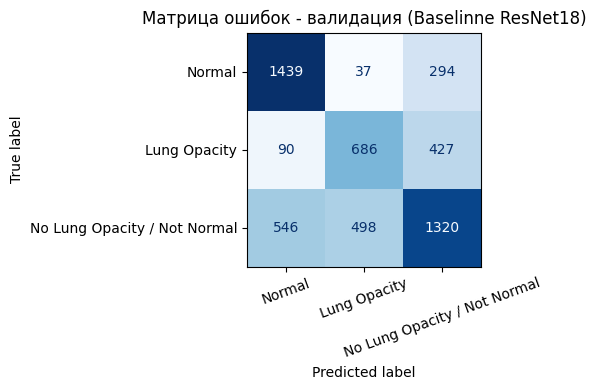

Матрица ошибок сохранена: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\figures\baseline_confusion_matrix.png


In [10]:
# Сопоставление id классов с названиям класса
id_to_label = {0:'Normal', 1:'Lung Opacity', 2:'No Lung Opacity / Not Normal'}

# Явно задаем порядок имен по id (0,1,2), чтобы отчет и оси были согласованы
target_names = [id_to_label[i] for i in sorted(id_to_label)]

# Текстовый отчет по метрикам (precision/recall/F1) для каждого класса и в среднем
# digits=4 - форматирование чисел до 4 знаков после запятой
print(classification_report(
    y_true, 
    y_pred, 
    target_names=target_names, digits=4))

# Считаем матрицу ошибок: количество объектов по парам (истинный класс, предсказанный класс)
conf_matrix = confusion_matrix(y_true, y_pred)

# Визуализация матрицы ошибок
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(conf_matrix, display_labels=target_names).plot(
    ax=ax, 
    cmap='Blues',          # цветовая схема
    values_format='d',     # формат значений - целые числа (counts)
    colorbar=False, 
    xticks_rotation=20     # поворот подписей классов на оси X
)

# Заголовок и компактная верстка
plt.title('Матрица ошибок - валидация (Baselinne ResNet18)')
plt.tight_layout()

# Сохранение рисунка в отчетную папку
fig_path = REPORTS_FIG / 'baseline_confusion_matrix.png'
REPORTS_FIG.mkdir(parents=True, exist_ok=True)  # на случай, если директории еще нет
plt.savefig(fig_path, dpi=150)

# Отображаем и логируем путь сохранения
plt.show()
print('Матрица ошибок сохранена:', fig_path)

Итоги baseline (ResNet18, замороженный backbone).

- Модель уверенно распознает класс Normal: F1 примерно 0.75, recall примерно 0.81.
- Наиболее сложным остается класс Lung Opacity: F1 примерно 0.56 - частые ошибки смешения с No Lung Opacity / Not Normal (оба патологические классы).
- Для класса No Lung Opacity / Not Normal качество умеренное: F1 примерно 0.59 - наблюдаются ошибки в сторону Normal.

В целом наблюдается асимметрия ошибок: сеть чаще путает между собой патологические классы и частично смещается в сторону 'здорового' класса - это типичный эффект дисбаланса данных.
Результаты подтверждают, что признаки 'здоровья' выражены сильнее, а надежное различение типов патологий требует дополнительной адаптации модели (fine-tuning последних слоев или усиления аугментаций).

### Cохранение отчета метрик модели в csv

In [11]:
# Сохраняем в основной CSV
REPORTS_DIR = REPORTS_FIG.parent  # 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
csv_path = REPORTS_DIR / 'baseline_metrics.csv'

save_model_report(
    model_name='ResNet18Baseline',
    y_true=y_true,
    y_pred=y_pred,
    y_prob=y_prob,
    target_names=target_names,
    num_epocs=EPOCS,
    csv_path=csv_path
)

Сводные метрики сохранены в CSV: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\baseline_metrics.csv


### Использование Grad-CAM

In [12]:
# целевой слой (последний блок перед GAP у ResNet18)
target_layer = model.net.layer4[-1].conv2
out_dir = REPORTS_FIG / 'gradcam_baseline'
out_dir.mkdir(parents=True, exist_ok=True)
n_show = min(6, len(ds_val))

with GradCAM(model=model, target_layers=[target_layer]) as cam:
    for i in range(n_show):
        img, y = ds_val[i]
        x = img.unsqueeze(0).to(device).requires_grad_(True)
        with torch.no_grad():
            pred_cls = int(model(x).argmax(1).item())

        # считаем CAM (в диапазоне [0..1], форма [H,W])
        grayscale_cam = cam(input_tensor=x, targets=[ClassifierOutputTarget(pred_cls)])[0]

        # Встроенное наложение тепловой карты на изображение
        base = img.squeeze().cpu().numpy()
        base = (base - base.min()) / (base.max() - base.min() + 1e-6)   # нормализация [0..1]
        rgb_img = np.repeat(base[..., None], 3, axis=2)                  # к show_cam_on_image нужен RGB [H,W,3]

        vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.65)  # uint8 RGB

        # сохраняем без самописных оберток
        pid = ds_val.df.iloc[i].patientId
        save_path = out_dir / f'{pid}_true{y}_pred{pred_cls}.png'
        Image.fromarray(vis).save(save_path)

print('Снимки Grad-CAM сохранены в:', out_dir)

Снимки Grad-CAM сохранены в: c:\Users\alexf\Desktop\rsna_pneumonia_project\reports\figures\gradcam_baseline


### Выводим результаты

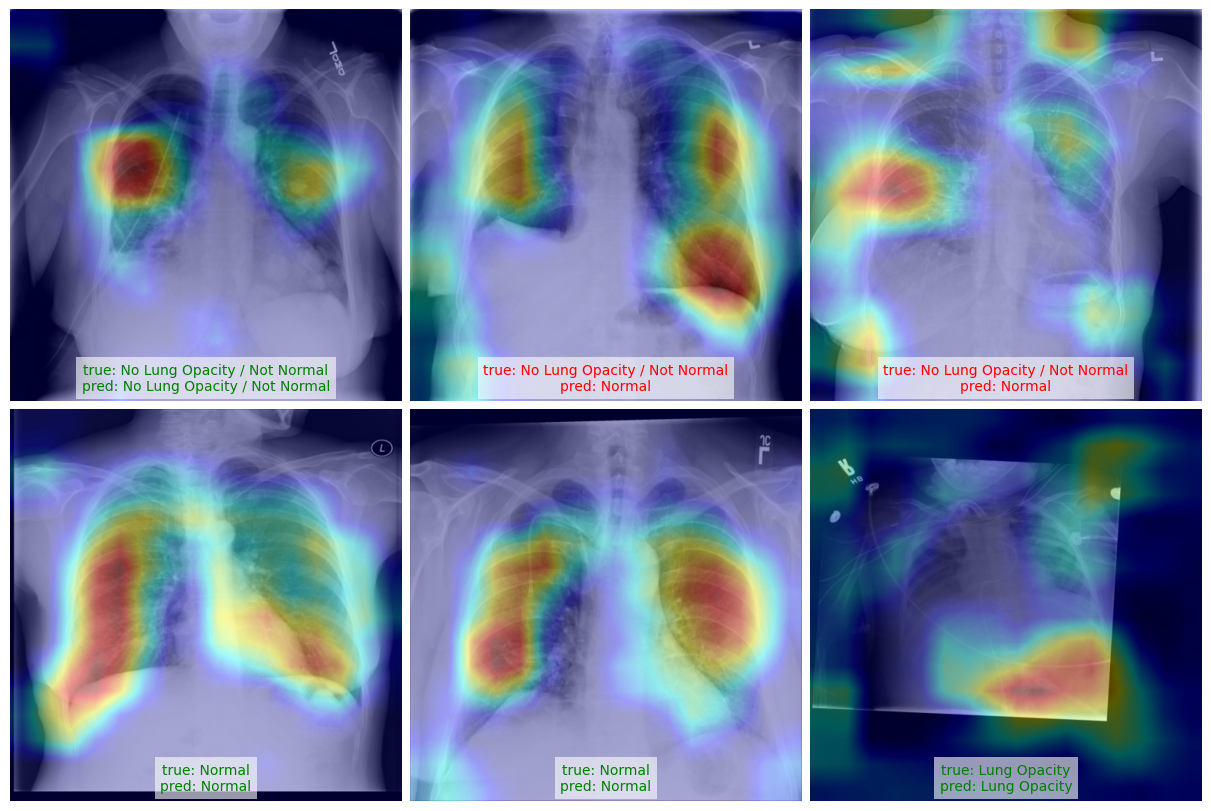

In [13]:
gradcam_dir = REPORTS_FIG / 'gradcam_baseline'
files = sorted(gradcam_dir.glob('*.png'))
id_to_label = {0:'Normal', 1:'Lung Opacity', 2:'No Lung Opacity / Not Normal'}

show_gradcam_png_grid(files, cols=3, id_to_label=id_to_label)

Сеть в большинстве примеров фокусируется внутри легочных полей, а не на рамки/метки - это позитивный сигнал.
Обобщающая способность базовой модели приемлемая: корректные предсказания 'Lung Opacity' сопровождаются локальными горячими зонами в типичных областях поражений.
Класс 'No Lung Opacity / Not Normal' чаще путается с 'Normal'; Grad‑CAM на таких ошибках без убедительных очагов. Отдельные кадры содержат технические артефакты (черные поля, границы прямоугольника экспозиции, провода). На примере 6-го снимка (портативный AP у лежачего пациента) виден повернутый прямоугольник на черном фоне; модель частично реагирует на границы, что потенциально может вносить шум.

Таким образом этап работы с базовой модель можно считать завершенным.